In [1]:
import sys
import os
sys.path.append(os.getcwd()+"/../..")
from src import paths

from src.utils import get_default_pydantic_model, SideEffect, SideEffectList

import pandas as pd
import torch

import json

import numpy as np

from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

default_model = get_default_pydantic_model("side_effects")
model = BertModel.from_pretrained(os.path.join(paths.MODEL_PATH, "medbert-512")).to(device)
tokenizer = BertTokenizer.from_pretrained(os.path.join(paths.MODEL_PATH, "medbert-512"))

Some weights of BertModel were not initialized from the model checkpoint at /cluster/dataset/midatams/inf-extr/resources/models/medbert-512 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def high_cosine_similarity(ground_truth:str, prediction:str, model:BertModel, tokenizer:BertTokenizer, threshhold:float = 0.7):
    """
    Calculate if the cosine similarity between the ground truth and the prediction is higher than the threshhold.

    Args:
        ground_truth (str): The ground truth text.
        prediction (str): The predicted text.
        model (BertModel): BertModel object to calculate the cosine similarity.
        tokenizer (BertTokenizer): BertTokenizer object to tokenize the text.
        threshhold (float, optional): The threshhold for the cosine similarity. Defaults to 0.7.

    Returns:
        bool: True if the cosine similarity is higher than the threshhold, False otherwise.
    """

    with torch.no_grad():
        ground_truth = model(**tokenizer(ground_truth, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device))["last_hidden_state"].to("cpu")
        prediction = model(**tokenizer(prediction, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device))["last_hidden_state"].to("cpu")
        ground_truth = ground_truth.mean(dim=1)
        prediction = prediction.mean(dim=1)
        return cosine_similarity(ground_truth, prediction).item() > threshhold

def preprocess_group(grouped_df: pd.DataFrame)->pd.DataFrame:
    """
    Preprocess a group of rows (grouped by obs index) from the dataframe. The preprocessing consists of:
    - Fusing all the unique side effects per medication with "," (so only one row per medication is left)
    - Splitting the medications by "/" if necessary

    Args:
        grouped_df (pd.DataFrame): A group of rows from the dataframe.

    Returns:
        pd.DataFrame: A dataframe with the group preprocessed.
    """

    df = []
    
    # group by medication name
    for med, group in grouped_df.groupby("medication"):
       # Fuse all the unique side effects with ","
        side_effects = group["side_effect"].unique()
        side_effects = ", ".join(side_effects)
        text = group["text"].iloc[0]
        original_text = group["original_text"].iloc[0]
        index = group["index"].iloc[0]

        new_row = {"medication": med, "side_effect": side_effects, "text": text, "original_text": original_text, "index": index, "successful": group["successful"].iloc[0]}
        # Append the new row to the dataframe
        df.append(new_row)

    return pd.DataFrame(df)

def prepare_results(path: str)->pd.DataFrame:
    """ 
    Prepare the results from the model to be compared with the labels. The preprocessing consists of:
    - Fixing the model answers, replacing them with the default model answer if they are invalid (in regards to JSON structure).
    - Grouping the results by index and preprocessing the group. (See preprocess_group() function for more details.)
    - Lowercasing and converting everything to string.

    Args:
        path (str): Path to the results file.
        
    Returns:
        pd.DataFrame: A dataframe with the results preprocessed.
    """
    results = torch.load(path)
    df = pd.DataFrame(results)

    df["successful"] = True

    # Fix model_answers
    for idx, row in df.iterrows():
        try:
            # Does model answer have key "side_effects"?
            answer = json.loads(row["model_answers"])

            # Is answer a valid SideEffectList?
            SideEffectList(**answer)

            # Is the element an empty list?
            if len(answer["side_effects"]) == 0:
                raise ValueError("Empty list")
            
            # Are all the elements valid SideEffect?
            for med in answer["side_effects"]:
                SideEffect(**med)
            
            df.at[idx, "model_answers"] = json.dumps(answer)

            
        except:
            df.at[idx, "model_answers"] = default_model.model_dump_json()
            # print(f"Error at index {idx}")
            df.at[idx, "successful"] = False
    
    dfs = []
    for idx, row in df.iterrows():
        row = row.to_dict()
        answer = json.loads(row["model_answers"])
        medications = answer["side_effects"]
        for med in medications:
            med["text"] = row.get("text", "")
            med["original_text"] = row.get("original_text", "")
            med["index"] = row.get("index", "")
            med["successful"] = row.get("successful", "")
            dfs.append((med))

    res = pd.DataFrame(dfs)

    res = res.sort_values(by="index")

    # Group by index and preprocess
    _dfs = []

    for index, group in res.groupby("index"):
        _dfs.append(preprocess_group(group))

    res = pd.concat(_dfs)

    # Convert everything to string and lowercase
    res = res.map(lambda x: str(x).lower())

    return res

def prepare_labels(path: str)->pd.DataFrame:
    """
    Prepare the labels to be compared with the results. The preprocessing consists of:
    - Lowercasing and converting everything to string.

    Args:
        path (str): Path to the labels file.

    Returns:

        pd.DataFrame: A dataframe with the labels preprocessed.
    """
    labels = pd.read_excel(path) 

    # Convert everything to string and lowercase
    labels = labels.map(lambda x: str(x).lower())

    return labels

def calculate_precision_recall_f1(ground_truth:list[str], predicted:list[str])->tuple[float, float, float]:
    """
    Calculate precision and recall from two lists of strings, allowing for partial string matches.
    A string does not have to be exactly the same to be considered a match, it is enough if one string is a substring of the other.
    This function is used to evaluate the medication names.

    Args:
        ground_truth (list[str]): List of ground truth medication names
        predicted (list[str]): List of predicted medication names

    Returns:
        tuple[float, float, float]: A tuple with the precision, recall and f1 score.
    """
    # Convert lists to sets for easier comparison
    ground_truth_set = set(ground_truth)
    predicted_set = set(predicted)

    # Initialize counters
    true_positives = 0
    false_positives = 0

    # Calculate True Positives and False Positives
    for pred_med in predicted_set:
        found_match = False
        for truth_med in ground_truth_set:
            if pred_med in truth_med or truth_med in pred_med:
                true_positives += 1
                found_match = True
                break
        if not found_match:
            false_positives += 1

    # Calculate False Negatives
    false_negatives = len(ground_truth_set) - true_positives

    # Calculate Precision
    if true_positives + false_positives == 0:
        precision = 0  # Handle division by zero
    else:
        precision = true_positives / (true_positives + false_positives)

    # Calculate Recall
    if true_positives + false_negatives == 0:
        recall = 0  # Handle division by zero
    else:
        recall = true_positives / (true_positives + false_negatives)

    # Calculate F1 Score
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

def string_match(ground_truth:list[dict], predicted:list[dict], model:BertModel, tokenizer:BertTokenizer, threshold:float=0.9)->tuple[float, float, float]:
    """ 
    Calculate if the strings match (based on cosine similarity) from two lists of dictionaries. This function is used to evaluate the side effects.

    Args:
        ground_truth (list): List of ground truth medication names and their side effect.
        predicted (list): List of predicted medication names and their side effect.
        model (BertModel): BertModel object to calculate the cosine similarity.
        tokenizer (BertTokenizer): BertTokenizer object to tokenize the text.
    """

    # Match the prediction to the ground truth with medication name
    tp = 0
    fn = 0
    fp = 0

    for pred_id, pred in enumerate(predicted):
        for gt_id, gt in enumerate(ground_truth):
            if pred["medication"] in gt["medication"] or gt["medication"] in pred["medication"]:
                if high_cosine_similarity([pred["side_effect"]], [gt["side_effect"]], model, tokenizer, threshold):
                    tp += 1
                else:
                    fp += 1
                    fn += 1
                # Remove the ground truth and prediction from the list
                ground_truth.pop(gt_id)
                predicted.pop(pred_id)

    # For remaining ground truth
    fn += len(ground_truth)
    fp += len(predicted)

    # Calculate Precision
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    # Calculate Recall
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    # Calculate F1 Score
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1


def create_metrics_df(labels_path:str, results_path:str, *args, **kwargs)->pd.DataFrame:
    """
    Create a dataframe with the metrics for each index. The metrics are:
    - Precision, Recall and F1 score for medication names
    - Precision, Recall and F1 score for side effects

    Args:
        labels_path (str): Path to the labels file.
        results_path (str): Path to the results file.

    Returns:
        pd.DataFrame: A dataframe with the metrics for each index.
    """
    
    labels = prepare_labels(labels_path)
    res = prepare_results(results_path)
    model = kwargs.get("model")
    tokenizer = kwargs.get("tokenizer")
    threshold = kwargs.get("threshold", 0.9)

    dfs = []
    for index, group in res.groupby("index"):
        text = group["text"].iloc[0]
        original_text = group["original_text"].iloc[0]
        index = group["index"].iloc[0]
        preds_med = group["medication"].to_list()
        preds_se = group["side_effect"].to_list()
        labels_med = labels[labels["index"] == index]["medication"].to_list()
        labels_se = labels[labels["index"] == index]["side_effect"].to_list()

        # Side effects
        ground_truth = labels[labels["index"] == index].to_dict(orient="records")
        predicted = group.to_dict(orient="records")
        assert model is not None and tokenizer is not None, "Model and tokenizer must be provided as keyword arguments for side effects evaluation."
        side_effects_precision, side_effects_recall, side_effects_f1 = string_match(ground_truth, predicted, model, tokenizer, threshold)

        # Medication
        ground_truth = labels[labels["index"] == index]["medication"].to_list()
        predicted = group["medication"].to_list()
        medication_precision, medication_recall, medication_f1 = calculate_precision_recall_f1(ground_truth, predicted)

        
        if group["successful"].iloc[0] == "false":
            successful = False
        else:
            successful = True

        dfs.append({"text": text, 
                    "original_text": original_text, 
                    "index": index, 
                    "preds_med": preds_med,
                    "labels_med": labels_med,
                    "preds_se": preds_se,
                    "labels_se": labels_se,
                    "successful": successful,
                    "side_effects_precision": side_effects_precision, "side_effects_recall": side_effects_recall, "side_effects_f1": side_effects_f1, "medication_precision": medication_precision, "medication_recall": medication_recall, "medication_f1": medication_f1})

    return pd.DataFrame(dfs)

def create_agg_metrics_df(labels_path:str, results_path:str, *args, **kwargs)->pd.DataFrame:
    """
    Create a dataframe with the aggregated metrics for the whole dataset. The metrics are:
    - Precision, Recall and F1 score for medication names
    - Precision, Recall and F1 score for side effects

    Args:
        labels_path (str): Path to the labels file.
        results_path (str): Path to the results file.
        scorer (BERTScorer): BERTScorer object to score the similarity between the side effects.

    Returns:
        pd.DataFrame: A dataframe with the aggregated metrics for the whole dataset.
    """
    metrics = create_metrics_df(labels_path, results_path, *args, **kwargs)

    # Calculate the average of the metrics
    agg_metrics = metrics.agg({"side_effects_precision": "mean", "side_effects_recall": "mean", "side_effects_f1": "mean", "medication_precision": "mean", "medication_recall": "mean", "medication_f1": "mean", "successful": "sum"})

    return agg_metrics

In [6]:
def summarize(paths:list[str], labels:str, *args, **kwargs)->pd.DataFrame:
    """
    Summarize the results from the model. The summary consists of:
    - Precision, Recall and F1 score for medication names
    - Precision, Recall and F1 score for side effects
    - Aggregated metrics for the whole dataset

    Args:
        paths (list): List of paths to the results files.
        labels (str): Path to the labels file.

    Returns:
        pd.DataFrame: A dataframe with the summary of the results.
    """
    dfs = []
    for path in paths:
        metrics = create_agg_metrics_df(labels, path, *args, **kwargs)
        path = str(path)
        if path.endswith("rag.pt"):
            metrics["approach"] = "S2A-1"
        elif path.endswith("s2a.pt"):
            metrics["approach"] = "S2A-2"
        else:
            metrics["approach"] = "Base"
        
        if "few_shot_vanilla" in path:
            metrics["strategy"] = "Few-Shot Base"
        elif "few_shot_instruction" in path:
            metrics["strategy"] = "Few-Shot Instruction"
        elif "zero_shot_vanilla" in path:
            metrics["strategy"] = "Zero-Shot Base"
        elif "zero_shot_instruction" in path:
            metrics["strategy"] = "Zero-Shot Instruction"
        else:
            ValueError("Unknown strategy")
        dfs.append(metrics)
    return pd.DataFrame(dfs)

# 13B

## Base

In [ ]:
# Zero Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_vanilla.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


In [ ]:
# Zero Shot instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_instruction.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

In [ ]:
# Few Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_vanilla_10_examples.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

In [ ]:
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

## RAG

In [ ]:
# Zero Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_vanilla_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


In [ ]:
# Zero Shot instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_instruction_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


In [ ]:
# Few Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_vanilla_10_examples_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

In [ ]:
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

## S2A

In [ ]:
# Zero Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_vanilla_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


In [ ]:
# Zero Shot instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_instruction_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


In [ ]:
# Few Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_vanilla_10_examples_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

In [ ]:
# Few Shot Instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

## Summary

In [7]:
def latex_metrics(metrics:pd.DataFrame)->str:
    """
    Convert the metrics dataframe to a latex table.
    """
    dfs = []
    for strat, group in metrics.groupby("strategy"):
        cols = [col for col in metrics.columns if col not in ["strategy", "approach"]]
        df_base = group[group["approach"] == "Base"][cols].reset_index(drop=True)
        df_base.columns = [f"{col}_base" for col in cols]
        df_rag = group[group["approach"] == "S2A-1"][cols].reset_index(drop=True)
        df_rag.columns = [f"{col}_rag" for col in cols]
        df_s2a = group[group["approach"] == "S2A-2"][cols].reset_index(drop=True)
        df_s2a.columns = [f"{col}_s2a" for col in cols]
        df = pd.concat([df_base, df_rag, df_s2a], axis=1)
        df["strategy"] = strat
        dfs.append(df)

    return pd.concat(dfs, axis=0)

In [8]:
file_paths = [paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_vanilla.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_instruction.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_vanilla_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_vanilla_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_instruction_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_vanilla_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_vanilla_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_zero_shot_instruction_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_vanilla_10_examples_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples_s2a.pt",]

In [ ]:
results = summarize(file_paths, paths.RESULTS_PATH/"side-effects/labels.xlsx", model=model, tokenizer=tokenizer, threshold = 0.7)
results = results.round(2)
# results.to_csv(paths.RESULTS_PATH/"side-effects/summary13b.csv", index=False)

In [ ]:
results

In [ ]:
thesis13b = latex_metrics(results)
thesis13b_precision = thesis13b[["strategy"] + [col for col in thesis13b.columns if "precision" in col]]
thesis13b_recall = thesis13b[["strategy"] + [col for col in thesis13b.columns if "recall" in col]]
thesis13b_f1 = thesis13b[["strategy"] + [col for col in thesis13b.columns if "f1" in col]]

# thesis13b_precision.to_csv(paths.RESULTS_PATH/"side-effects/thesis13b_precision.csv", index=False)
# thesis13b_recall.to_csv(paths.RESULTS_PATH/"side-effects/thesis13b_recall.csv", index=False)
# thesis13b_f1.to_csv(paths.RESULTS_PATH/"side-effects/thesis13b_f1.csv", index=False)

- Model seems to have difficulties if there is no medication mentioned with side effects. The tuned model does not have this problem I think, show example
- also split medications that contain "/" into two lists
- concatenate the side effects for the same medications with ","

# 7B

## Base

In [ ]:
# Zero Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_vanilla.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


In [ ]:
# Zero Shot instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_instruction.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


In [ ]:
# Few Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_vanilla_10_examples.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

In [ ]:
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_instruction_10_examples.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

## RAG

In [ ]:
# Zero Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_vanilla_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


In [ ]:
# Zero Shot instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_instruction_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


In [ ]:
# Few Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_vanilla_10_examples_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

In [ ]:
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_instruction_10_examples_rag.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

## S2A

In [ ]:
# Zero Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_vanilla_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


In [ ]:
# Zero Shot instruction
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_instruction_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)


In [ ]:
# Few Shot Vanilla
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_vanilla_10_examples_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

In [ ]:
create_agg_metrics_df(paths.RESULTS_PATH/"side-effects/labels.xlsx", paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_instruction_10_examples_s2a.pt", model=model, tokenizer=tokenizer, threshold = 0.5)

In [ ]:
file_paths7b = [paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_vanilla.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_instruction.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_vanilla_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_instruction_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_vanilla_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_instruction_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_vanilla_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_instruction_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_vanilla_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_zero_shot_instruction_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_vanilla_10_examples_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-7b_4bit_few_shot_instruction_10_examples_s2a.pt",]

In [ ]:
results7b = summarize(file_paths7b, paths.RESULTS_PATH/"side-effects/labels.xlsx", model=model, tokenizer=tokenizer, threshold = 0.5)
results7b = results7b.round(2)
# results7b.to_csv(paths.RESULTS_PATH/"side-effects/summary7b.csv", index=False)

In [ ]:
results7b

In [ ]:
thesis7b = latex_metrics(results7b)
thesis7b_precision = thesis7b[["strategy"] + [col for col in thesis7b.columns if "precision" in col]]
thesis7b_recall = thesis7b[["strategy"] + [col for col in thesis7b.columns if "recall" in col]]
thesis7b_f1 = thesis7b[["strategy"] + [col for col in thesis7b.columns if "f1" in col]]

# thesis7b_precision.to_csv(paths.RESULTS_PATH/"side-effects/thesis7b_precision.csv", index=False)
# thesis7b_recall.to_csv(paths.RESULTS_PATH/"side-effects/thesis7b_recall.csv", index=False)
# thesis7b_f1.to_csv(paths.RESULTS_PATH/"side-effects/thesis7b_f1.csv", index=False)

# 13B Lora

In [10]:
file_paths13b_lora_1024 = [
                paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_zero_shot_vanilla.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_zero_shot_instruction.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_vanilla_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_instruction_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_zero_shot_vanilla_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_zero_shot_instruction_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_vanilla_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_instruction_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_zero_shot_vanilla_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_zero_shot_instruction_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_vanilla_10_examples_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_instruction_10_examples_s2a.pt",]

In [11]:
results13b_lora_1024 = summarize(file_paths13b_lora_1024, paths.RESULTS_PATH/"side-effects/labels.xlsx", model=model, tokenizer=tokenizer, threshold = 0.7)

In [12]:
results13b_lora_1024 = results13b_lora_1024.round(2)
results13b_lora_1024

,side_effects_precision,side_effects_recall,side_effects_f1,medication_precision,medication_recall,medication_f1,successful,approach,strategy
0,0.16,0.33,0.20,0.31,0.72,0.41,99.0,Base,Zero-Shot Base
1,0.20,0.37,0.25,0.39,0.78,0.49,97.0,Base,Zero-Shot Instruction
2,0.29,0.49,0.34,0.39,0.69,0.47,95.0,Base,Few-Shot Base
3,0.29,0.50,0.34,0.42,0.76,0.50,98.0,Base,Few-Shot Instruction
4,0.26,0.43,0.30,0.40,0.76,0.49,100.0,S2A-1,Zero-Shot Base
5,0.30,0.47,0.34,0.42,0.77,0.51,98.0,S2A-1,Zero-Shot Instruction
6,0.38,0.51,0.41,0.47,0.63,0.50,98.0,S2A-1,Few-Shot Base
7,0.35,0.63,0.42,0.41,0.76,0.50,99.0,S2A-1,Few-Shot Instruction
8,0.44,0.50,0.46,0.76,0.86,0.79,100.0,S2A-2,Zero-Shot Base
9,0.55,0.57,0.55,0.88,0.92,0.89,95.0,S2A-2,Zero-Shot Instruction


In [13]:
file_paths13b_lora_512 = [
                paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_zero_shot_vanilla.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_zero_shot_instruction.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_vanilla_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_instruction_10_examples.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_zero_shot_vanilla_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_zero_shot_instruction_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_vanilla_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_instruction_10_examples_rag.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_zero_shot_vanilla_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_zero_shot_instruction_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_vanilla_10_examples_s2a.pt",
              paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_instruction_10_examples_s2a.pt",]

In [14]:
results13b_lora_512 = summarize(file_paths13b_lora_512, paths.RESULTS_PATH/"side-effects/labels.xlsx", model=model, tokenizer=tokenizer, threshold = 0.7)

In [15]:
results13b_lora_512 = results13b_lora_512.round(2)
results13b_lora_512

,side_effects_precision,side_effects_recall,side_effects_f1,medication_precision,medication_recall,medication_f1,successful,approach,strategy
0,0.16,0.35,0.21,0.32,0.72,0.42,99.0,Base,Zero-Shot Base
1,0.19,0.38,0.24,0.37,0.79,0.48,98.0,Base,Zero-Shot Instruction
2,0.32,0.54,0.38,0.45,0.77,0.53,97.0,Base,Few-Shot Base
3,0.25,0.47,0.30,0.39,0.76,0.48,96.0,Base,Few-Shot Instruction
4,0.25,0.40,0.29,0.39,0.76,0.48,99.0,S2A-1,Zero-Shot Base
5,0.28,0.45,0.32,0.41,0.78,0.50,99.0,S2A-1,Zero-Shot Instruction
6,0.34,0.42,0.36,0.45,0.56,0.47,99.0,S2A-1,Few-Shot Base
7,0.31,0.59,0.38,0.40,0.78,0.49,99.0,S2A-1,Few-Shot Instruction
8,0.42,0.48,0.44,0.78,0.87,0.81,100.0,S2A-2,Zero-Shot Base
9,0.53,0.56,0.54,0.87,0.92,0.88,96.0,S2A-2,Zero-Shot Instruction


# Threshold
Will compare effects of threshold for few shot instruction s2a on results

In [16]:
threshold_files = [
    paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b_4bit_few_shot_instruction_10_examples_s2a.pt",
    paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-512-lora-merged_4bit_few_shot_instruction_10_examples_s2a.pt",
    paths.RESULTS_PATH/"side-effects/side-effects_outlines_Llama2-MedTuned-13b-1024-lora-merged_4bit_few_shot_instruction_10_examples_s2a.pt",
                   ]

In [17]:
thresholds = np.linspace(0, 1, 11)
dfs = []
for threshold in thresholds:
    _df = summarize(threshold_files, paths.RESULTS_PATH/"side-effects/labels.xlsx", model=model, tokenizer=tokenizer, threshold = threshold)
    _df["model"] = ["Llama2-MedTuned-13B", "Llama2-MedTuned-13B-lora-512", "Llama2-MedTuned-13B-lora-1024"]
    _df["threshold"] = threshold
    dfs.append(_df)

In [18]:
df_thresholds = pd.concat(dfs, axis=0)
df_thresholds.drop(columns=["successful", "medication_precision", "medication_recall", "medication_f1",	"successful","approach", "strategy"], inplace=True)

In [19]:
def plot_line_plot_group(x:pd.Series, y:pd.Series, groups:pd.Series, title:str = "Line Plot",
                             xlabel:str = "Threshold", ylabel:str = "Recall"):
    """
    Plot a line plot with different color for group.

    Args:
        x (pd.Series): x values.
        y (pd.Series): y values.
        groups (pd.Series): group values.
        title (str): Title of the plot.
        color_palette (np.ndarray): Color palette to use.
    """

    assert len(x) == len(y) == len(groups), "Length of x, y and group must be the same."

    unique_groups = groups.unique()

    data = pd.DataFrame({"x": x, "y": y, "groups": groups})

    plt.figure(figsize=(10, 6))

    sns.lineplot(data=data, x="x", y="y", hue="groups", palette="viridis")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.grid(True)
    plt.show()

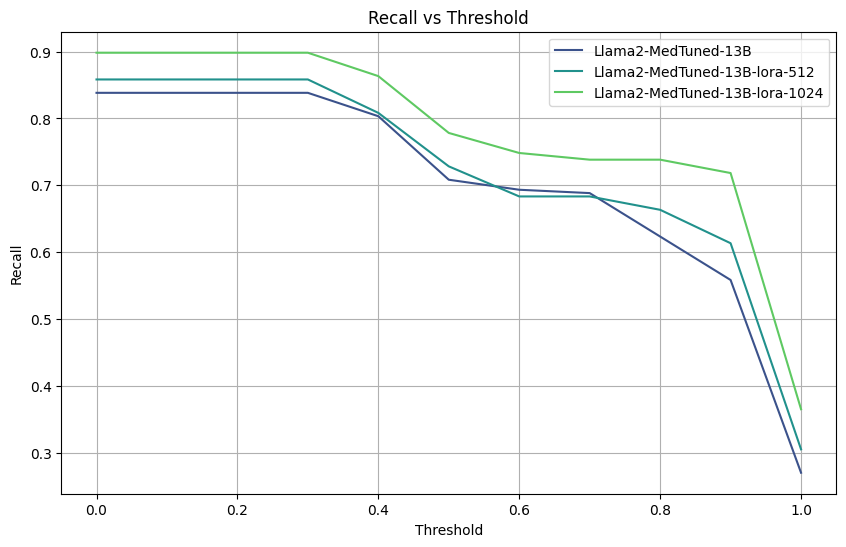

In [20]:
plot_line_plot_group(df_thresholds["threshold"], df_thresholds["side_effects_recall"], df_thresholds["model"], title="Recall vs Threshold", ylabel="Recall", xlabel="Threshold")

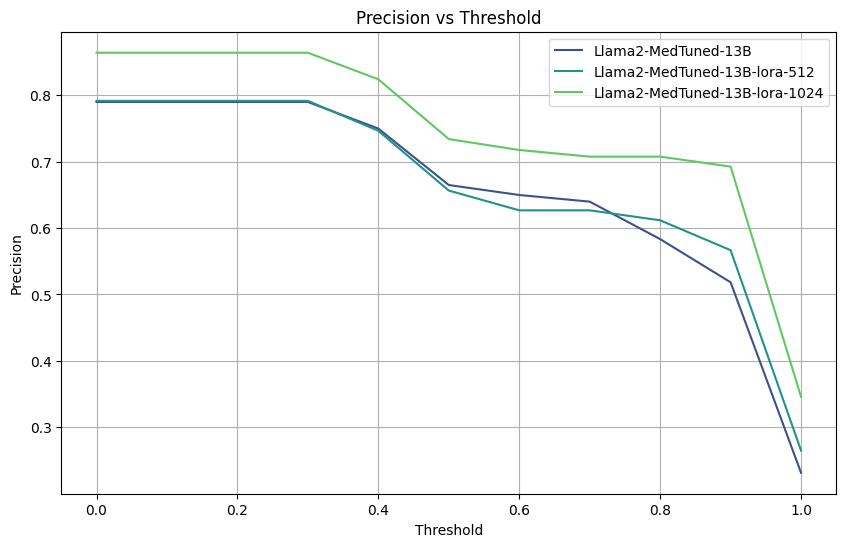

In [21]:
plot_line_plot_group(df_thresholds["threshold"], df_thresholds["side_effects_precision"], df_thresholds["model"], title="Precision vs Threshold", ylabel="Precision", xlabel="Threshold")

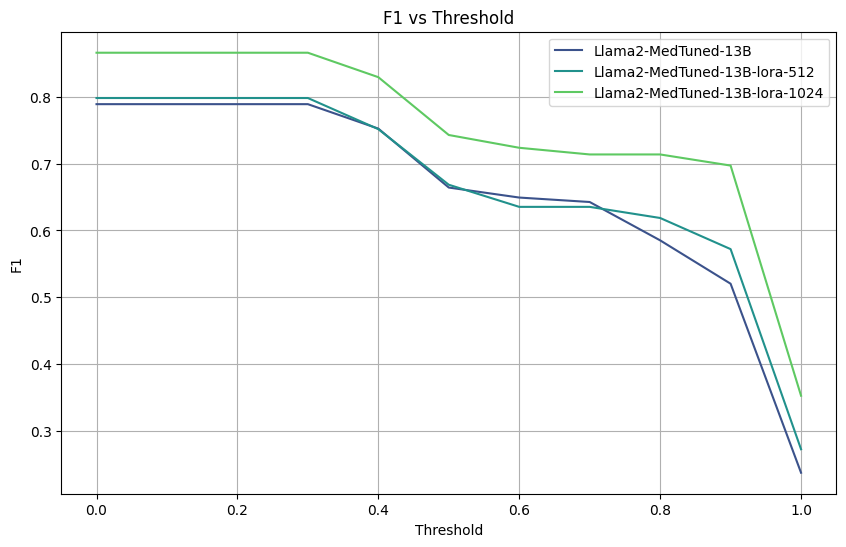

In [22]:
plot_line_plot_group(df_thresholds["threshold"], df_thresholds["side_effects_f1"], df_thresholds["model"], title="F1 vs Threshold", ylabel="F1", xlabel="Threshold")